<a href="https://colab.research.google.com/github/lorenzotomada/Applied_Mathematics/blob/main/Code/AM_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Iterative methods for linear systems**

See https://github.com/mgirfogl/numerical-analysis-2023-2024/blob/main/material/21-PS-Exercises-python-iterative-methods-linear-system/Linear_system_iterative.pdf for more theoretical details.

Consider the equation
\begin{cases}
    -u_{xx}(x) = f(x), x\in (0,1) \\
    u(0)=u(1)=0.
\end{cases}

For the numerical discretization of the problem, we consider a **Finite Difference (FD) Approximation**. Let $n$ be an integer, a consider a uniform subdivision of the interval $(0,1)$ using $n$ equispaced points, denoted by $\{x_i\}_{i=0}^n$ . Moreover, let $u_i$ be the FD approximation of $u(x_i)$, and similarly $f_i \approx f(x_i)$.

The linear system that we need to solve is
$$
u_i = 0 \qquad\qquad\qquad\qquad i=0,
$$
$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad\qquad\qquad i=1, \ldots, n-1,\qquad\qquad\qquad(P)
$$
$$
u_i = 0 \qquad\qquad\qquad\qquad i=n.
$$


In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

In [2]:
# Same as in lab6.
n = 30
h = 1./(n-1)
x = linspace(0, 1, n)

In [3]:
a = -ones((n-1,))
b = 2*ones((n))
A = 1/h**2*(diag(a,-1) + diag(b) + diag(a, +1))
f = x*(1-x)

A[0,:] = 0
A[:, 0] = 0
A[0, 0] =1
f[0] = 0

A[-1,:] = 0
A[:, -1] = 0
A[-1, -1] =1
f[-1] = 0

u = linalg.solve(A, f)

## Jacobi

$$
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j\neq i} a_{ij}x_j^k\right)
$$



In [4]:
def jacobi(A, b, nmax = 10000, eps = 1e-10):
  N = len(A)
  x = zeros_like(b)
  x_old = zeros_like(b)
  tol = eps + 1
  it = 0

  while tol > eps and it < nmax:
    for i in range(0, N-1):
      x[i] = 1./A[i,i]*(b[i]- dot(A[i, 0:i], x_old[0:i])- dot(A[i, i+1:N], x_old[i+1:N]))
      # Two dot products because it will be useful for the next method

    res = b - dot(A, x) # Residual
    tol = linalg.norm(res, 2)
    x_old = x.copy()
    it+=1

  print('The number of iterations is ', it)
  print('The norm of the residual is ', tol)
  return x

In [5]:
sol_jacobi = jacobi(A, f)
print('The relative error is ', linalg.norm((sol_jacobi-u)/linalg.norm(u)))
# Relative error

The number of iterations is  3914
The norm of the residual is  9.965885316539395e-11
The relative error is  1.01435369692299e-10


## Gauss-Seidel

$$
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j=0}^{i-1} a_{ij}x_j^{k+1} - \sum_{j=i+1}^{N} a_{ij}x_j^k\right)
$$

In [6]:
def gauss_seidel(A, b, nmax = 10000, eps = 1e-10):
  N = len(A)
  x = zeros_like(b)
  x_old = zeros_like(b)
  tol = eps + 1
  it = 0

  while tol > eps and it < nmax:
    for i in range(0, N-1):
      x[i] = 1./A[i,i]*(b[i]- dot(A[i, 0:i], x[0:i])- dot(A[i, i+1:N], x_old[i+1:N]))
      # Two dot product because it will be useful for the next method

    res = b - dot(A, x)
    tol = linalg.norm(res, 2)
    x_old = x.copy()
    it+=1

  print('The number of iterations is ', it)
  print('The norm of the residual is ', tol)
  return x

In [7]:
sol_gauss_seidel = gauss_seidel(A, f)
print('The relative error is ',linalg.norm((sol_gauss_seidel-u)/linalg.norm(u)))

The number of iterations is  1958
The norm of the residual is  9.975573046289024e-11
The relative error is  1.0068983192453529e-10


   ## Gradient method
   $$
   {\bf r}^k = {\bf b} - A {\bf x}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf r}^{k^{T}} {\bf r}^k}{{\bf r}^{k^{T}} A{\bf r}^k}
   $$
   
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf r}^k
   $$
   
   ### Preconditioned gradient method
   $$
   P{\bf z}^k =  {\bf r}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf z}^{k^{T}} {\bf r}^k}{{\bf z}^{k^{T}} A{\bf z}^k}
   $$

   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf z}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k  - \alpha^k A{\bf z}^k
   $$

   We will implement the preconditioned version. The standard one can be get using the identity as preconditioner.

In [8]:
def gradient(A, b, P, nmax = 10000, eps = 1e-10):
  N = len(A)
  x = zeros_like(b)
  tol = eps + 1
  res = b - dot(A, x)
  counter = 0

  while counter < nmax and tol > eps:
    z = linalg.solve(P, res)
    alpha = dot(z, res)/dot(z, dot(A, z))
    x += alpha*z
    res -= alpha*dot(A,z)
    counter += 1
    tol = linalg.norm(b-dot(A, x), 2)

  print('The number of iterations is ', counter)
  print('The norm of the residual is ', tol)
  return x

In [9]:
sol_grad = gradient(A, f, identity(len(A)))
print('The relative error is ',linalg.norm(sol_grad - u)/linalg.norm(u))

The number of iterations is  3183
The norm of the residual is  9.968180120829321e-11
The relative error is  7.477371613409447e-11


If we manage to choose a preconditioner which is "similar" to $A$, then $P^{-1}A$ will be close to the identity and we will be left with an easy system.

As a matter of fact, if we take $A$ itself as preconditioner, we have the exact solution in just $1$ step:

In [10]:
sol_pre_grad = gradient(A, f, A)
print('The relative error is ',linalg.norm(sol_pre_grad - u)/linalg.norm(u))

The number of iterations is  1
The norm of the residual is  1.7727152017483662e-14
The relative error is  1.9043722965187744e-15


Clearly, this is not doable in practice, as it would require to know $A^{-1}$, in which case we would already know the solution and there would be no need to use an iterative method.

Preconditioners can be chosen, for instance, extracting the diagonal of $A$ or considering an (incomplete) $LU$ factorization of $A$.

In any case $P$ should be easily invertible.

## Conjugate gradient
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{{\bf p}^{k^{T}} A{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf r}^{k+1}}{(A{\bf p}^{k})^{T}  {\bf p}^k}
   \beta^k = \frac{{z^{k+1}}^{T}{\bf r}^{k+1}}{(A{\bf p}^{k})^{T}  {\bf p}^k}
   $$
   vedere le slide
   
   $$
   {\bf p}^{k+1} = {\bf r}^{k+1} - \beta^k{\bf p}^k
   $$

   
   ### Preconditioned conjugate gradient
   
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{(A{\bf p}^{k})^{T}{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

$$
P{\bf z}^{k+1} = {\bf r}^{k+1}
$$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf z}^{k+1}}{{\bf p}^{k^T}A  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf z}^{k+1} - \beta^k{\bf p}^k
   $$


  We will implement the preconditioned version. The standard one can be get using the identity as preconditioner.

In [11]:
def conjugate_gradient(A, b, P, nmax = len(A), eps = 1e-10): # Theoretically, it
# is a direct method, so it should make no sense to consider a number of
# iterations greater than the dimension of A.
# Actually, due to floating point arithmetic, in unlucky cases the exact
# solution might not be reached even after this amount of steps. This is not the
# standard situation, though.
  N = len(A)
  x = zeros_like(b)
  tol = eps + 1
  res = b - dot(A, x)
  counter = 0
  p_old = zeros_like(b)
  rho_old = 1.

  while counter < nmax and tol > eps:
    z = linalg.solve(P,res)
    rho = dot(res, z)
    counter += 1

    if (counter > 1):
      beta = rho/rho_old
      p =  z + beta*p_old
    else:
      p = z

    q = dot(A, p)
    alpha = rho/dot(p, q)
    x += p*alpha
    res -= q*alpha
    p_old = p
    rho_old = rho
    tol = linalg.norm(b-dot(A, x), 2)

  print('The number of iterations is ', counter)
  print('The norm of the residual is ', tol)
  return x

In [12]:
sol_conj_gradient = conjugate_gradient(A, f, identity(len(A)))
print('The relative error is ',linalg.norm((sol_conj_gradient-u)/linalg.norm(u)))

# Same example as before, using A as preconditioner:

sol_precond_conj_gradient = conjugate_gradient(A, f, A)
print('The relative error is ',linalg.norm((sol_precond_conj_gradient-u)/linalg.norm(u)))

The number of iterations is  14
The norm of the residual is  3.625573392809256e-14
The relative error is  1.180953962485736e-15
The number of iterations is  1
The norm of the residual is  1.7727152017483662e-14
The relative error is  1.9043722965187744e-15


Since I like plotting, let us conclude by:

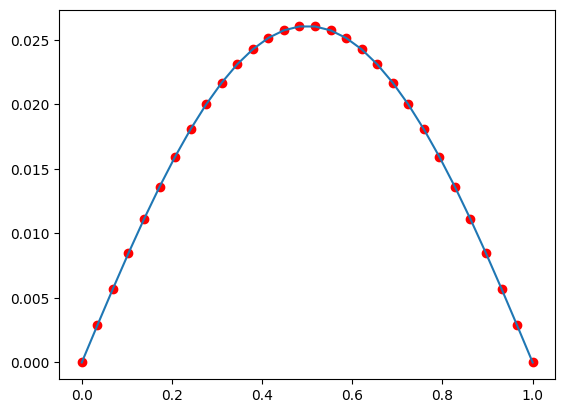

In [13]:
plot(x, sol_conj_gradient, 'ro')
plot(x, u)